In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import tempfile
temp_dir = tempfile.TemporaryDirectory()
from casatasks import simobserve, tclean, exportfits
import os
import shutil
from casatools import table
from astropy.constants import c
from astropy.time import Time
import astropy.units as U
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import AdaptiveKernel, GaussianKernel, CubicSplineKernel, DiracDeltaKernel
from natsort import natsorted
import math
from math import pi
from tqdm import tqdm
import time
from time import strftime, gmtime
import dask
from typing import Optional
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from spectral_cube import SpectralCube
import h5py
os.environ['MPLCONFIGDIR'] = temp_dir.name

def load_fits(inFile):
    hdu_list = fits.open(inFile)
    data = hdu_list[0].data
    header = hdu_list[0].header
    hdu_list.close()
    return data, header

(1, 128, 394, 394) (1, 128, 394, 394)


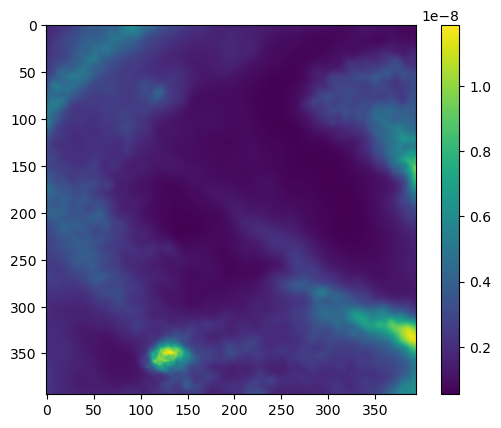

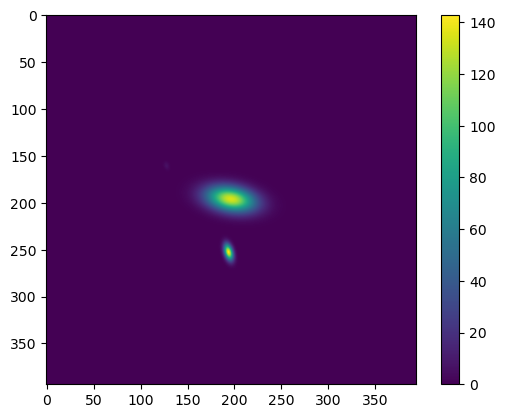

In [7]:
data_dir = '/media/storage/sims'
extended, extended_header = load_fits(os.path.join(data_dir, 'skymodel_0.fits'))
gaussian, gaussian_header = load_fits(os.path.join(data_dir, 'skymodel_1.fits'))
print(extended.shape, gaussian.shape)


plt.imshow(np.sum(extended[0,:,:], axis=0))
plt.colorbar()
plt.show()
plt.imshow(np.sum(gaussian[0,:,:], axis=0))
plt.colorbar()
